In [1]:
from pyspark import SparkContext
sc=SparkContext("local[*]")

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=PySparkShell, master=local[*]) created by <module> at /home/hduser/anaconda2/lib/python2.7/site-packages/IPython/utils/py3compat.py:286 

In [1]:
sc.master
global Path    
if sc.master[0:5]=="local" :
   Path="file:/home/hduser/pythonwork/PythonProject/"
else:   
   Path="hdfs://master:9000/user/hduser/"

In [2]:
RawUserRDD1= sc.textFile(Path+"suppliers.csv")
RawUserRDD1.take(5)

[u's1,Smith,London',
 u's2,Jones,Paris',
 u's3,Blake,Paris',
 u's4,Clark,London',
 u's5,Adams,Athens']

In [3]:
userRDD1 =RawUserRDD1.map(lambda line: line.split(","))
userRDD1 .take(5)

[[u's1', u'Smith', u'London'],
 [u's2', u'Jones', u'Paris'],
 [u's3', u'Blake', u'Paris'],
 [u's4', u'Clark', u'London'],
 [u's5', u'Adams', u'Athens']]

In [4]:
sqlContext = SparkSession.builder.getOrCreate()
from pyspark.sql import Row
user_Rows1 = userRDD1.map(lambda p:
     Row(
         sid=p[0], 
         sname=p[1],
         location=p[2]
            )
)
user_Rows1.take(5)

[Row(location=u'London', sid=u's1', sname=u'Smith'),
 Row(location=u'Paris', sid=u's2', sname=u'Jones'),
 Row(location=u'Paris', sid=u's3', sname=u'Blake'),
 Row(location=u'London', sid=u's4', sname=u'Clark'),
 Row(location=u'Athens', sid=u's5', sname=u'Adams')]

In [5]:
user_df1= sqlContext.createDataFrame(user_Rows1)
user_df1 .printSchema()

root
 |-- location: string (nullable = true)
 |-- sid: string (nullable = true)
 |-- sname: string (nullable = true)



In [6]:
user_df1.show(5)

+--------+---+-----+
|location|sid|sname|
+--------+---+-----+
|  London| s1|Smith|
|   Paris| s2|Jones|
|   Paris| s3|Blake|
|  London| s4|Clark|
|  Athens| s5|Adams|
+--------+---+-----+



In [7]:
user_df1.registerTempTable("suppliers")

In [8]:
sqlContext.sql(" SELECT *  FROM suppliers ").show()

+--------+---+-----+
|location|sid|sname|
+--------+---+-----+
|  London| s1|Smith|
|   Paris| s2|Jones|
|   Paris| s3|Blake|
|  London| s4|Clark|
|  Athens| s5|Adams|
+--------+---+-----+



In [10]:
RawUserRDD2= sc.textFile(Path+"catalog.csv")
RawUserRDD2.take(5)

[u's1,p1,200', u's2,p3,400', u's2,p5,100', u's3,p2,200', u's3,p4,500']

In [11]:
userRDD2 =RawUserRDD2.map(lambda line: line.split(","))
userRDD2 .take(5)

[[u's1', u'p1', u'200'],
 [u's2', u'p3', u'400'],
 [u's2', u'p5', u'100'],
 [u's3', u'p2', u'200'],
 [u's3', u'p4', u'500']]

In [12]:
sqlContext = SparkSession.builder.getOrCreate()
from pyspark.sql import Row
user_Rows2 = userRDD2.map(lambda p:
     Row(
         sid=p[0], 
         pid=p[1],
         amount=int(p[2])
            )
)
user_Rows2.take(5)

[Row(amount=200, pid=u'p1', sid=u's1'),
 Row(amount=400, pid=u'p3', sid=u's2'),
 Row(amount=100, pid=u'p5', sid=u's2'),
 Row(amount=200, pid=u'p2', sid=u's3'),
 Row(amount=500, pid=u'p4', sid=u's3')]

In [13]:
user_df2= sqlContext.createDataFrame(user_Rows2)
user_df2 .printSchema()

root
 |-- amount: long (nullable = true)
 |-- pid: string (nullable = true)
 |-- sid: string (nullable = true)



In [14]:
user_df2.registerTempTable("catalog")

In [15]:
joined_df=user_df1.join(user_df2 ,  \
                                 user_df1.sid == user_df2.sid, "left_outer")

joined_df.printSchema()    

root
 |-- location: string (nullable = true)
 |-- sid: string (nullable = true)
 |-- sname: string (nullable = true)
 |-- amount: long (nullable = true)
 |-- pid: string (nullable = true)
 |-- sid: string (nullable = true)



In [16]:
sqlContext.sql(" SELECT *  FROM catalog ").show()

+------+---+---+
|amount|pid|sid|
+------+---+---+
|   200| p1| s1|
|   400| p3| s2|
|   100| p5| s2|
|   200| p2| s3|
|   500| p4| s3|
|   300| p6| s4|
|   100| p2| s5|
|   500| p5| s5|
|   200| p6| s5|
|   100| p1| s5|
|   200| p3| s5|
|   800| p4| s5|
+------+---+---+



In [34]:
joined_df.show()


+--------+---+-----+------+---+---+
|location|sid|sname|amount|pid|sid|
+--------+---+-----+------+---+---+
|  London| s4|Clark|   300| p6| s4|
|  Athens| s5|Adams|   100| p2| s5|
|  Athens| s5|Adams|   500| p5| s5|
|  Athens| s5|Adams|   200| p6| s5|
|  Athens| s5|Adams|   100| p1| s5|
|  Athens| s5|Adams|   200| p3| s5|
|  Athens| s5|Adams|   800| p4| s5|
|   Paris| s2|Jones|   400| p3| s2|
|   Paris| s2|Jones|   100| p5| s2|
|   Paris| s3|Blake|   200| p2| s3|
|   Paris| s3|Blake|   500| p4| s3|
|  London| s1|Smith|   200| p1| s1|
+--------+---+-----+------+---+---+



In [31]:
jdf=joined_df.select("sname","amount").groupby("sname").count()
jdf.show(10)


+-----+-----+
|sname|count|
+-----+-----+
|Jones|    2|
|Smith|    1|
|Blake|    2|
|Adams|    6|
|Clark|    1|
+-----+-----+



In [32]:
import pandas as pd
GroupBysname_pandas_df =jdf.toPandas().set_index('sname')
GroupBysname_pandas_df

,count
sname,
Jones,2
Smith,1
Blake,2
Adams,6
Clark,1


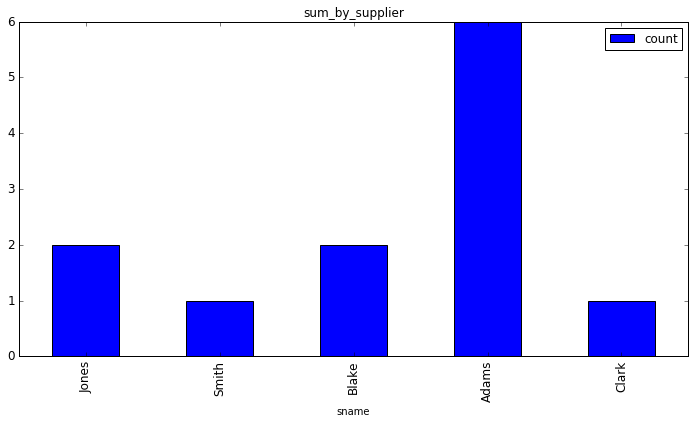

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = GroupBysname_pandas_df ['count']  \
            .plot(kind='bar', title ="sum_by_supplier",figsize=(12,6),legend=True, fontsize=12)
plt.show()

In [21]:
jdf2=joined_df.select("pid","amount").groupby("pid").sum("amount")
jdf2.show(10)

+---+-----------+
|pid|sum(amount)|
+---+-----------+
| p5|        600|
| p2|        300|
| p6|        500|
| p1|        300|
| p3|        600|
| p4|       1300|
+---+-----------+



In [22]:
GroupBypid_pandas_df =jdf2.toPandas().set_index('pid')
GroupBypid_pandas_df

,sum(amount)
pid,
p5,600
p2,300
p6,500
p1,300
p3,600
p4,1300


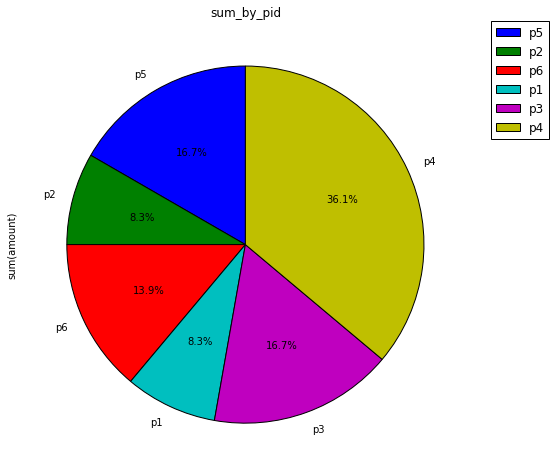

In [23]:
%matplotlib inline
# ax = GroupBypid_pandas_df ['sum(amount)']  \
#             .plot(kind='pie', title ="sum_by_pname",figsize=(12,6),legend=True, fontsize=12)
# plt.show()

ax =GroupBypid_pandas_df['sum(amount)'].plot(kind='pie',
           title ="sum_by_pid",figsize=(8,8),startangle=90,autopct='%1.1f%%')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [24]:
RawUserRDD3= sc.textFile(Path+"parts.csv")
userRDD3 =RawUserRDD3.map(lambda line: line.split(","))

sqlContext = SparkSession.builder.getOrCreate()
from pyspark.sql import Row
user_Rows3 = userRDD3.map(lambda p:
     Row(
         pid=p[0], 
         pname=p[1],
         pcolor=p[2]
            )
)

user_df3= sqlContext.createDataFrame(user_Rows3)
user_df3.registerTempTable("parts")

In [25]:
sqlContext.sql(" SELECT *  FROM catalog ").show()

+------+---+---+
|amount|pid|sid|
+------+---+---+
|   200| p1| s1|
|   400| p3| s2|
|   100| p5| s2|
|   200| p2| s3|
|   500| p4| s3|
|   300| p6| s4|
|   100| p2| s5|
|   500| p5| s5|
|   200| p6| s5|
|   100| p1| s5|
|   200| p3| s5|
|   800| p4| s5|
+------+---+---+



In [26]:
sqlContext.sql(" SELECT *  FROM parts ").show()

+------+---+-----+
|pcolor|pid|pname|
+------+---+-----+
|   Red| p1|  Nut|
| Green| p2| Bolt|
|  Blue| p3|Screw|
|   Red| p4|Screw|
|  Blue| p5|  Cam|
|   Red| p6|  Cog|
+------+---+-----+



In [27]:
joined_df2=user_df2.join(user_df3, user_df2.pid == user_df3.pid, "left_outer")
joined_df2.show()

+------+---+---+------+---+-----+
|amount|pid|sid|pcolor|pid|pname|
+------+---+---+------+---+-----+
|   100| p5| s2|  Blue| p5|  Cam|
|   500| p5| s5|  Blue| p5|  Cam|
|   200| p2| s3| Green| p2| Bolt|
|   100| p2| s5| Green| p2| Bolt|
|   300| p6| s4|   Red| p6|  Cog|
|   200| p6| s5|   Red| p6|  Cog|
|   200| p1| s1|   Red| p1|  Nut|
|   100| p1| s5|   Red| p1|  Nut|
|   400| p3| s2|  Blue| p3|Screw|
|   200| p3| s5|  Blue| p3|Screw|
|   500| p4| s3|   Red| p4|Screw|
|   800| p4| s5|   Red| p4|Screw|
+------+---+---+------+---+-----+



In [28]:
jdf3=joined_df2.select("pname","amount").groupby("pname").sum("amount")
jdf3.show(10)

+-----+-----------+
|pname|sum(amount)|
+-----+-----------+
|  Cog|        500|
|  Cam|        600|
| Bolt|        300|
|Screw|       1900|
|  Nut|        300|
+-----+-----------+



In [29]:
GroupBypname_pandas_df =jdf3.toPandas().set_index('pname')
GroupBypname_pandas_df

,sum(amount)
pname,
Cog,500
Cam,600
Bolt,300
Screw,1900
Nut,300


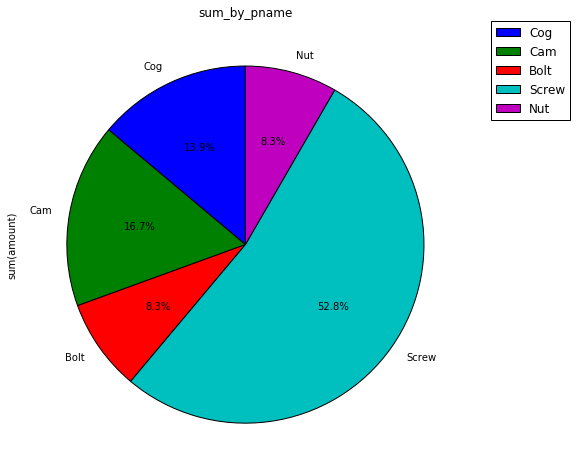

In [30]:
%matplotlib inline

ax =GroupBypname_pandas_df['sum(amount)'].plot(kind='pie',
           title ="sum_by_pname",figsize=(8,8),startangle=90,autopct='%1.1f%%')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()